In [2]:
from src.dm import DataModule

dm = DataModule(val_trans={'Resize': {'width': 224, 'height': 224}}, pin_memmory=True, num_workers=24)
dm.setup()

/home/sensio/miniconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [3]:
import glob 

glob.glob('*efficientnet*.ckpt')

['Unet-efficientnet-b3-val_iou=0.8535.ckpt',
 'Unet-efficientnet-b3-val_iou=0.8166.ckpt']

In [4]:
from src.models import SMP

model = SMP.load_from_checkpoint('Unet-efficientnet-b3-val_iou=0.8166.ckpt')
model.hparams

"backbone":       efficientnet-b3
"batch_size":     64
"gpus":           1
"load_from":      False
"log":            True
"loss":           dice
"lr":             5e-05
"max_epochs":     100
"model":          Unet
"num_workers":    24
"optimizer":      Adam
"pin_memory":     True
"precision":      16
"pretrained":     imagenet
"scheduler":      {'OneCycleLR': {'pct_start': 0.05, 'max_lr': 0.0005, 'total_steps': 100, 'verbose': True}}
"shuffle_train":  True
"train_batches":  1.0
"train_trans":    {'PadIfNeeded': {'min_width': 224, 'min_height': 224, 'border_mode': 0}, 'RandomResizedCrop': {'width': 224, 'height': 224}, 'HorizontalFlip': {}, 'VerticalFlip': {}, 'Transpose': {}, 'Rotate': {}, 'GridDistortion': {}}
"val_batches":    1.0
"val_trans":      {'Resize': {'width': 224, 'height': 224}}
"val_with_train": False

In [5]:
import nibabel as nib
from tqdm import tqdm
import torch
import random

model.eval()
model.cuda()
ious = []
with torch.no_grad():
    for batch in tqdm(dm.val_dataloader()):
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = model(x)
        ious.append(model.iou(y_hat, y).item())
    
np.mean(ious)

100%|██████████| 31/31 [00:08<00:00,  3.62it/s]


0.8144101788920741

In [6]:
import ttach as tta

tta_model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')

tta_model.eval()
tta_model.cuda()
ious = []
with torch.no_grad():
    for batch in tqdm(dm.val_dataloader()):
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = tta_model(x)
        ious.append(model.iou(y_hat, y).item())
        
np.mean(ious)

100%|██████████| 31/31 [00:18<00:00,  1.65it/s]


0.8247225688349816

/home/sensio/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sensio/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/sensio/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


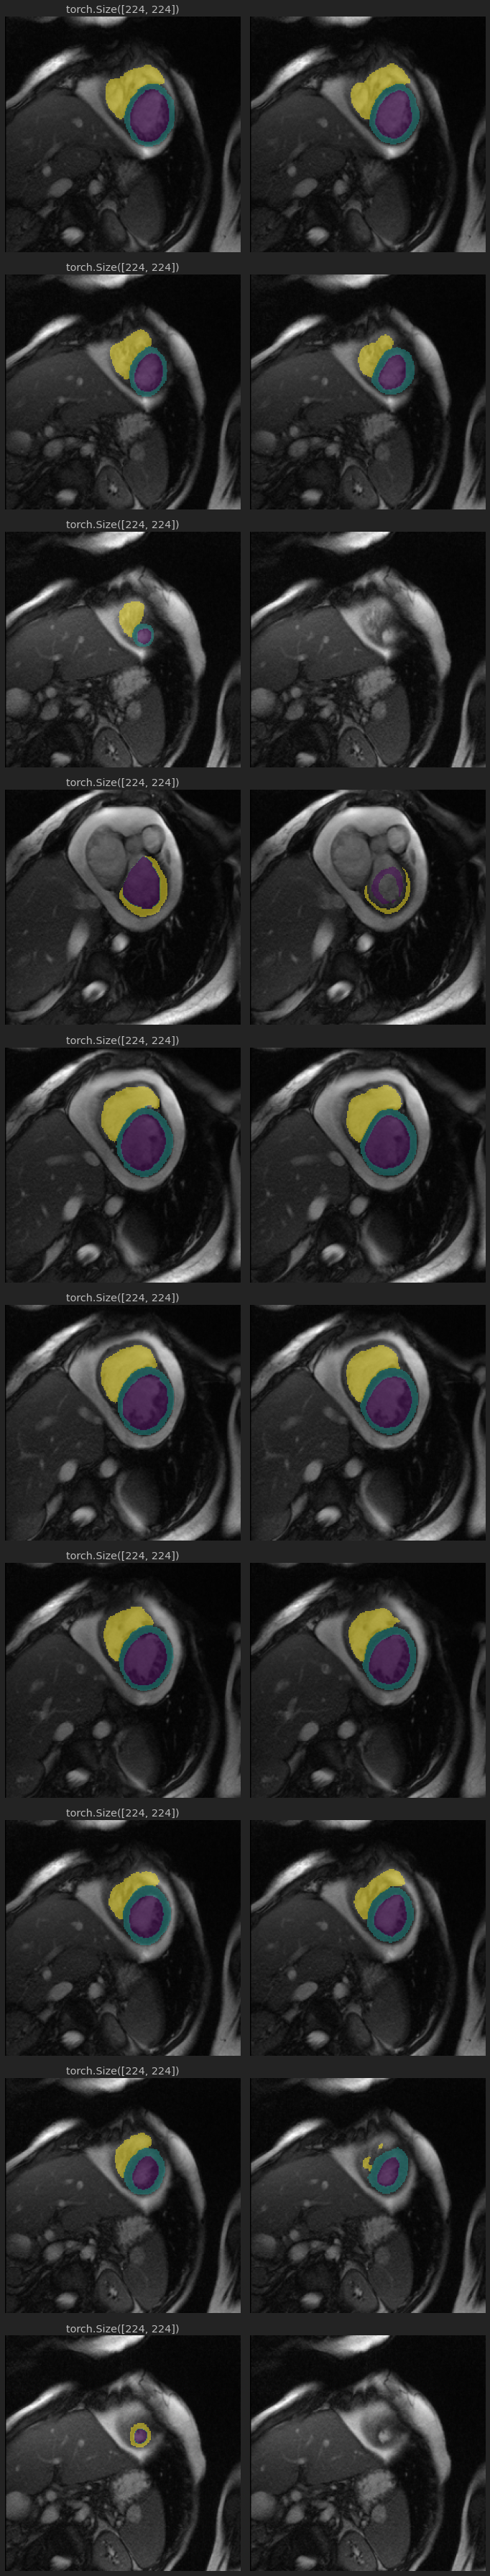

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5*len(x)))
preds = torch.argmax(y_hat, axis=1).float()
gts = torch.argmax(y, axis=1).float()
for i, (_x, _y, _yh) in enumerate(zip(x.cpu(), gts.cpu(), preds.cpu())):
    _x = _x[0]
    ax = plt.subplot(len(x), 2, i*2 + 1)
    ax.imshow(_x, cmap='gray')
    _y[_y == 0] = np.nan
    ax.imshow(_y, alpha=0.5)
    ax.axis('off')
    ax.set_title(_x.shape)
    ax = plt.subplot(len(x), 2, i*2 + 2)
    ax.imshow(_x, cmap='gray')
    _yh[_yh == 0] = np.nan
    ax.imshow(_yh, alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
path = 'data/MnM-2/validation'
patients = os.listdir(path)
len(patients)

40

In [9]:
dest = 'preds'
#!rm -rf {dest}
os.makedirs(dest)

FileExistsError: [Errno 17] File exists: 'preds'

In [10]:
def pred_la(patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata() / max_val[file]
    resized = resize(image=img_data[...,0])['image']
    img_t = torch.from_numpy(resized).float().unsqueeze(0)
    with torch.no_grad():
        output = tta_model(img_t.unsqueeze(0).cuda())
        output = torch.sigmoid(output)
    mask = torch.argmax(output[0,...], axis=0).float().cpu().numpy()
    mask_resized = np.rint(A.Resize(*img.shape)(image=mask)['image'])[...,None]
    nib.save(nib.Nifti1Image(mask_resized, img.affine), f'{dest}/{patient}/{patient}_{file}_pred.nii.gz')  
    
def pred_sa(patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata() / max_val[file]
    resized = resize(image=img_data)['image']
    img_t = torch.from_numpy(resized).float().permute(2,0,1).unsqueeze(1)
    with torch.no_grad():
        output = tta_model(img_t.cuda())
        output = torch.sigmoid(output)
    masks = torch.argmax(output, axis=1).float().cpu().permute(1,2,0).numpy()
    masks_resized = np.rint(A.Resize(*img.shape[:2])(image=masks)['image'])
    nib.save(nib.Nifti1Image(masks_resized, img.affine), f'{dest}/{patient}/{patient}_{file}_pred.nii.gz')  

In [ ]:
import nibabel as nib
from tqdm import tqdm
import albumentations as A
import torch

max_val = {
    'LA_ED': 4104.,
    'LA_ES': 7875.,
    'SA_ED': 11510.0,
    'SA_ES': 9182.0
}
resize = A.Resize(224, 224)
model.eval()
model.cuda()
for patient in tqdm(patients):
    os.makedirs(f'{dest}/{patient}', exist_ok=True)
    pred_la(patient, 'LA_ED')
    pred_la(patient, 'LA_ES')
    pred_sa(patient, 'SA_ED')
    pred_sa(patient, 'SA_ES')

 90%|█████████ | 36/40 [00:50<00:05,  1.38s/it]

In [ ]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(patients))
sample = patients[ix]
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(1, 4, 1)
image_path = f'{path}/{sample}/{sample}_LA_ED.nii.gz'
img = nib.load(image_path).get_fdata()
ax.imshow(img,cmap='gray')
ax.axis('off')
ax.set_title(img.shape)
ax = plt.subplot(1, 4, 2)
image_path = f'{dest}/{sample}/{sample}_LA_ED_pred.nii.gz'
mask = nib.load(image_path).get_fdata()
ax.imshow(img, cmap='gray')
ax.set_title(np.unique(mask))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
ax = plt.subplot(1, 4, 3)
image_path = f'{path}/{sample}/{sample}_LA_ES.nii.gz'
img = nib.load(image_path).get_fdata()
ax.imshow(img,cmap='gray')
ax.axis('off')
ax.set_title(img.shape)
ax = plt.subplot(1, 4, 4)
image_path = f'{dest}/{sample}/{sample}_LA_ES_pred.nii.gz'
mask = nib.load(image_path).get_fdata()
ax.imshow(img, cmap='gray')
ax.set_title(np.unique(mask))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
ed_img = nib.load(f'{path}/{sample}/{sample}_SA_ED.nii.gz').get_fdata()
channels = ed_img.shape[-1]

ed_pred = nib.load(f'{dest}/{sample}/{sample}_SA_ED_pred.nii.gz').get_fdata()
es_img = nib.load(f'{path}/{sample}/{sample}_SA_ES.nii.gz').get_fdata()
es_pred = nib.load(f'{dest}/{sample}/{sample}_SA_ES_pred.nii.gz').get_fdata()

fig = plt.figure(figsize=(20, channels*5))
for c in range(channels):
    ax = plt.subplot(channels, 4, 4*c + 1)
    ax.imshow(ed_img[...,c],cmap='gray')
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 2)
    ax.imshow(ed_img[...,c], cmap='gray')
    mask = ed_pred[...,c]
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 3)
    ax.imshow(es_img[...,c],cmap='gray')
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 4)
    ax.imshow(es_img[...,c],cmap='gray')
    mask = es_pred[...,c]
    ax.set_title(np.unique(mask))
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()